In [2]:
#ALGORITHM = 'XG Boost'
#ALGORITHM = 'Linear Regression (Ridge)'
#ALGORITHM = 'KNN'
#ALGORITHM = 'Decision Tree'
#ALGORITHM = 'Random Forest'
#ALGORITHM = 'CatBoost'
ALGORITHM = 'Light Gradient Boosting'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['explore param']
#DATA_DETAIL = ['no scale','no dummies']
#DATA_DETAIL = ['no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: Light Gradient Boosting
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [3]:
%pip install catboost
%pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 22.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 75.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 13.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [5]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def make_pipeline():
    return Pipeline([
        #('mms', MinMaxScaler()),
        ('std_scaler', StandardScaler()),
        ('model', get_chosen_model(ALGORITHM))
    ])


starter_pipe = make_pipeline()
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', LGBMRegressor())])

In [7]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [8]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v06.csv
(46871, 9)


In [9]:
df.head(30)

Price  bedrooms  bathrooms  nearestStation  location.latitude  \
14520525  550000.0       3.0        1.0        0.274316          51.529950   
27953107  400000.0       2.0        2.0        0.305845          51.549390   
33593487  579950.0       2.0        1.0        0.438045          51.447180   
35271294  370000.0       2.0        1.0        0.399307          51.449568   
35429088  599950.0       2.0        1.0        0.238187          51.577030   
44749111  475000.0       2.0        1.0        0.410550          51.370050   
46204665  435000.0       3.0        2.0        0.314779          51.539070   
49020666  200000.0       1.0        1.0        0.875911          51.539959   
49036279  275000.0       2.0        1.0        0.474368          51.541780   
49303873  450000.0       3.0        2.0        0.577040          51.524880   
52064391  349950.0       2.0        2.0        0.212734          51.470800   
52187854  450000.0       1.0        1.0        0.446802          51.527199   
52675628  490000.0       2.0        2.0        0.215040          51.501114   
52845963  200000.0       2.0        1.0        0.650562          51.398040   
52913496  220000.0       1.0        1.0        0.945991          51.539383   
53609433  489995.0       1.0        1.0        0.087081          51.532620   
53649578  284950.0       1.0        1.0        0.806597          51.479890   
53938989  450000.0       2.0        1.0        0.775203          51.658287   
54713232  332000.0       2.0        1.0        0.319226          51.612300   
54904122  365000.0       2.0        1.0        0.260722          51.593595   
54991934  430000.0       3.0        1.0        0.497268          51.528720   
55043230  260000.0       1.0        1.0        0.384607          51.544430   
55187658  430000.0       2.0        2.0        0.289033          51.507570   
55531367  599950.0       2.0        1.0        0.406725          51.467410   
55768232  550000.0       2.0        1.0        0.478349          51.472890   
55805965  280000.0       2.0        1.0        0.742859          51.520910   
55839051  599950.0       2.0        1.0        0.259168          51.579186   
55940994  385000.0       2.0        2.0        0.403987          51.376930   
56449305  380000.0       2.0        1.0        0.310271          51.600483   
57221413  475000.0       3.0        2.0        0.409784          51.497260   

          location.longitude  latitude_deviation  longitude_deviation  \
14520525           -0.207020            0.030230             0.102600   
27953107           -0.482600            0.049670             0.378180   
33593487           -0.338770            0.052540             0.234350   
35271294           -0.140154            0.050152             0.035734   
35429088           -0.141230            0.077310             0.036810   
44749111           -0.212410            0.129670             0.107990   
46204665           -0.198935            0.039350             0.094515   
49020666           -0.380863            0.040239             0.276443   
49036279            0.037890            0.042060             0.142310   
49303873            0.187200            0.025160             0.291620   
52064391           -0.361820            0.028920             0.257400   
52187854           -0.202898            0.027479             0.098478   
52675628            0.026315            0.001394             0.130735   
52845963           -0.076812            0.101680             0.027608   
52913496           -0.382239            0.039663             0.277819   
53609433           -0.107860            0.032900             0.003440   
53649578           -0.078500            0.019830             0.025920   
53938989           -0.207902            0.158567             0.103482   
54713232           -0.119860            0.112580             0.015440   
54904122            0.022046            0.093875             0.126466   
54991934            0.039180            0.029000             

In [10]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [11]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


count           mean            std            min  \
Price                46871.0  425069.390775  107227.324906  100000.000000   
bedrooms             46871.0       1.992469       0.828837       1.000000   
bathrooms            46871.0       1.182074       0.409879       1.000000   
nearestStation       46871.0       0.438847       0.325942       0.000000   
location.latitude    46871.0      51.497049       0.077085      51.298317   
location.longitude   46871.0      -0.113269       0.156489      -0.498315   
latitude_deviation   46871.0       0.064317       0.042573       0.000000   
longitude_deviation  46871.0       0.124202       0.095607       0.000000   

                               25%            50%            75%  \
Price                349950.000000  425000.000000  515000.000000   
bedrooms                  1.000000       2.000000       3.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.227169       0.367971       0.559620   
location.latitude        51.438861      51.499977      51.556183   
location.longitude       -0.210796      -0.102230      -0.010343   
latitude_deviation        0.028876       0.058595       0.094362   
longitude_deviation       0.043560       0.098984       0.192684   

                               max  
Price                600000.000000  
bedrooms                  7.000000  
bathrooms                 5.000000  
nearestStation            7.197700  
location.latitude        51.683185  
location.longitude        0.279726  
latitude_deviation        0.201403  
longitude_deviation       0.393895

In [12]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


count           mean            std            min  \
Price                46871.0  425069.390775  107227.324906  100000.000000   
bedrooms             46871.0       1.992469       0.828837       1.000000   
bathrooms            46871.0       1.182074       0.409879       1.000000   
nearestStation       46871.0       0.438847       0.325942       0.000000   
location.latitude    46871.0      51.497049       0.077085      51.298317   
location.longitude   46871.0      -0.113269       0.156489      -0.498315   
latitude_deviation   46871.0       0.064317       0.042573       0.000000   
longitude_deviation  46871.0       0.124202       0.095607       0.000000   

                               25%            50%            75%  \
Price                349950.000000  425000.000000  515000.000000   
bedrooms                  1.000000       2.000000       3.000000   
bathrooms                 1.000000       1.000000       1.000000   
nearestStation            0.227169       0.367971       0.559620   
location.latitude        51.438861      51.499977      51.556183   
location.longitude       -0.210796      -0.102230      -0.010343   
latitude_deviation        0.028876       0.058595       0.094362   
longitude_deviation       0.043560       0.098984       0.192684   

                               max  
Price                600000.000000  
bedrooms                  7.000000  
bathrooms                 5.000000  
nearestStation            7.197700  
location.latitude        51.683185  
location.longitude        0.279726  
latitude_deviation        0.201403  
longitude_deviation       0.393895

In [13]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [14]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


Price      bedrooms    bathrooms  nearestStation  \
count   44127.000000  44127.000000  44127.00000    44127.000000   
mean   425224.642373      1.990981      1.18134        0.438522   
std    107203.332660      0.827621      0.40893        0.324152   
min    100000.000000      1.000000      1.00000        0.000000   
25%    349950.000000      1.000000      1.00000        0.227551   
50%    425000.000000      2.000000      1.00000        0.368351   
75%    515000.000000      3.000000      1.00000        0.559486   
max    600000.000000      7.000000      5.00000        7.197700   

       location.latitude  location.longitude  latitude_deviation  \
count       44127.000000        44127.000000        44127.000000   
mean           51.496711           -0.113106            0.064544   
std             0.077267            0.155863            0.042583   
min            51.298317           -0.498315            0.000000   
25%            51.438303           -0.210633            0.029023   
50%            51.498780           -0.101910            0.058904   
75%            51.556343           -0.010854            0.094620   
max            51.683185            0.279726            0.201403   

       longitude_deviation  
count         44127.000000  
mean              0.123699  
std               0.095220  
min               0.000000  
25%               0.043551  
50%               0.098750  
75%               0.191727  
max               0.393895

In [15]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

print(X_train[0])

if 'forest' in ALGORITHM.lower() or ALGORITHM.lower()=='light gradient boosting':
    y_train_orig = y_train
    y_train = y_train.ravel()
    print(y_train_orig, y_train)
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



[3.00000000e+00 3.00000000e+00 3.16613257e-01 5.14597600e+01
 1.29390000e-01 3.99600000e-02 2.33810000e-01 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00]
[[525000.]
 [225000.]
 [475000.]
 ...
 [435000.]
 [315000.]
 [600000.]] [525000. 225000. 475000. ... 435000. 315000. 600000.]
(39714, 11) (4413, 11) (39714,) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [16]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [17]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()

print("default_model_params:\n", default_model_params)
print("---------------------")
print("sklearn.metrics.get_scorer_names():\n",sklearn.metrics.get_scorer_names())

default_model_params:
 {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
---------------------
sklearn.metrics.get_scorer_names():
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentag

In [18]:
#jh
options_block = get_hyperparameters(ALGORITHM, use_gpu, prefix='../../../')

if 'explore param' in DATA_DETAIL:
    def automl_step(param_options, vary):
        for key, value in param_options.items():
            #print(key, value, vary)
            if key != vary and key != 'model__' + vary:
                param_options[key] = [param_options[key][0]]
        return param_options

    #options_block = automl_step(options_block, "model__epochs")
    explore_param = "alpha"
    options_block = automl_step(options_block, explore_param)


if 'forest' in ALGORITHM.lower():
    OVERRIDE_N_ITER = 5
    if use_gpu:
        OVERRIDE_JOBS = 8

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

if 'forest' in ALGORITHM.lower():
    verbose = 2

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)

if not_catboost and len(param_options.keys()) > 2 and not already_timed:
    already_timed = True
    %timeit starter_pipe.fit(X_train, y_train)


print('\n\nHyperparameters:')
param_options if not_catboost else options_block

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1
The slowest run took 5.15 times longer than the fastest. This could mean that an intermediate result is being cached.
492 ms ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hyperparameters:


{'model__boosting_type': ['gbdt', 'rf', 'dart', 'goss'],
 'model__colsample_bytree': [0.6],
 'model__is_unbalance': [True, False],
 'model__learning_rate': [0.0005, 0.005, 0.05, 0.5, 5],
 'model__metric': ['auc'],
 'model__min_child_samples': [20],
 'model__n_estimators': [64, 132, 264],
 'model__num_iterations': [25, 50, 100, 500, 1000],
 'model__num_leaves': [20],
 'model__verbose': [1]}

In [19]:
from catboost import CatBoostRegressor, Pool


def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


if not_catboost:
    if ALGORITHM_DETAIL == 'grid search':
        crossval_runner = GridSearchCV(
            estimator=starter_pipe,
            param_grid=param_options,
            cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True, #n_iter=n_iter,
            #error_score='raise'
        )
    else:
        crossval_runner = RandomizedSearchCV(
            estimator=starter_pipe,
            param_distributions=param_options,
            cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
            verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
            refit=refit,
            return_train_score=True,  #n_iter=n_iter,
            n_iter=n_iter,  # 1, #3
            #error_score='raise'
    )
    cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
        crossval_runner, X_train, y_train, fits=cv * n_iter)

else:

    #pool = Pool(df, cat_features=['tenure.tenureType'], label=df['Price'].values)
    pool_Xtrain = Pool(X_train, cat_features=[7], label=y_train)
    #pool_Xtest = Pool(X_train, cat_features=[7], label=y_train)
    pool_Xtest = Pool(X_test, cat_features=[7], label=y_test)
    import sys
    starter_model = model=CatBoostRegressor(iterations=3, depth=3, learning_rate=0.1, loss_function='RMSE', objective='RMSE')

    output = starter_model.randomized_search(options_block, # param_options,
                                    X=pool_Xtrain, # X_train,
                                    #y=y_train,
                                    #cat_features=[],
                                    cv=5,
                                    n_iter=100,
                                    partition_random_seed=101,
                                    calc_cv_statistics=True,
                                    #search_by_train_test_split=True,
                                    refit=True,
                                    shuffle=True,
                                    stratified=None,
                                    #train_size=0.8,
                                    #train_size=1,
                                    verbose=True,
                                    plot=True,
                                    log_cout=sys.stdout,
                                    log_cerr=sys.stderr)

    cat_params, cat_cv_results = output['params'], output['cv_results']
    crossval_runner = {"best_params_": cat_params, "cv_results_": cat_cv_results, "best_estimator_": None}
crossval_runner


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 425460.839024
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [I

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/pytho

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/pytho

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/pytho

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 425410.602168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number 

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 425410.602168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGB

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boo

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
81 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 425241.939971
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further 

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boo

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/pytho

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/pytho

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 26476, number of used features: 10
[LightGBM] [Info] Start training from score 424854.378720
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data poin

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{ali

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
81 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971
Total fit/CV time      : 357 seconds   (1668606829.598721 ==> 1668607187.1674695)

average fit/score time = 1.38s/0.09s
max fit/score time     = 26.26s/0.58s
refit time             = 13.27s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('model', LGBMRegressor())]),
                   n_iter=100, n_jobs=3,
                   param_distributions={'model__boosting_type': ['gbdt', 'rf',
                                                                 'dart',
                                                                 'goss'],
                                        'model__colsample_bytree': [0.6],
                                        'model__is_unbalance': [True, False],
                                        'model__learning_rate': [0.0005, 0.005,
                                                                 0.05, 0.5, 5],
                                        'model__metric': ['auc'],
                                        'model__min_child_samples': [20],
                                        'model__n_estimators': [64, 132, 264],
                                        'model__num_iterations': [25, 50, 100,
                                                                  500, 1000],
                                        'model__num_leaves': [20],
                                        'model__verbose': [1]},
                   return_train_score=True, scoring='r2', verbose=1)

In [20]:
if not_catboost:
    best_estimator_pipe = crossval_runner.best_estimator_

    if not_catboost and debug_mode:
        crossval_runner.cv_results_

In [21]:
starter_model
if True:
    print(starter_model)
if not not_catboost:
    print(cat_params)
    print(cat_cv_results)

LGBMRegressor()


In [22]:
if not_catboost:
    crossval_runner.best_params_
else:
    crossval_runner["best_params_"]

In [23]:
if not_catboost:
    cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df if not_catboost else ''

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
76      15.043873      0.131190         0.517302        0.001150   
8        5.272155      0.177729         0.185249        0.001830   
68       1.166172      0.128907         0.385707        0.007394   
33       1.196901      0.172167         0.391283        0.009497   
39       0.171882      0.008024         0.030933        0.002016   
..            ...           ...              ...             ...   
70       0.031240      0.001331         0.000000        0.000000   
50       0.031715      0.000484         0.000000        0.000000   
67       0.032042      0.002777         0.000000        0.000000   
23       0.031411      0.000035         0.000000        0.000000   
25       0.032442      0.001679         0.000000        0.000000   

   param_model__verbose param_model__num_leaves param_model__num_iterations  \
76                    1                      20                        1000   
8                     1                      20                         500   
68                    1                      20                        1000   
33                    1                      20                        1000   
39                    1                      20                         100   
..                  ...                     ...                         ...   
70                    1                      20                        1000   
50                    1                      20                         500   
67                    1                      20                          25   
23                    1                      20                          50   
25                    1                      20                         500   

   param_model__n_estimators param_model__min_child_samples  \
76                       264                             20   
8                         64                             20   
68                        64                             20   
33                       132                             20   
39                       264                             20   
..                       ...                            ...   
70                        64                             20   
50                       264                             20   
67                       132                             20   
23                       132                             20   
25                        64                             20   

   param_model__metric  ... split1_test_score split2_test_score  \
76                 auc  ...          0.688021          0.699795   
8                  auc  ...          0.683099          0.695027   
68                 auc  ...          0.668667          0.678101   
33                 auc  ...          0.668667          0.678101   
39                 auc  ...          0.659350          0.668768   
..                 ...  ...               ...               ...   
70                 auc  ...               NaN               NaN   
50                 auc  ...               NaN               NaN   
67                 auc  ...               NaN               NaN   
23                 auc  ...               NaN               NaN   
25                 auc  ...               NaN               NaN   

   mean_test_score std_test_score rank_test_score  split0_train_score  \
76        0.694935       0.005022               1            0.823282   
8         0.688621       0.004909               2            0.782998   
68        0.674614       0.004226               3            0.911181   
33        0.674614       0.004226               3            0.911181   
39        0.664856       0.004007               5            0.738672   
..             ...            ...             ...                 ...   
70             NaN            NaN              96                 NaN   
50             NaN            NaN              97                 NaN   
67             NaN 

In [24]:
if not_catboost and debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
cv_results_df[xx].head(7) if not_catboost and debug_mode else ''

''

In [25]:
cv_results_df[xx].tail(7) if not_catboost and debug_mode else ''

''

In [26]:
if not_catboost:
    cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

    cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
    # if 'Neural' not in ALGORITHM:
    #     cv_columns.insert(2, 'mean_train_score')
    cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)

cv_results_df_full_sorted if not_catboost else ''

params2  rank_test_score  mean_test_score  \
0   1/20/1000/264/20/auc/0.5/False/0.6/dart                1         0.694935   
1      1/20/500/64/20/auc/0.5/True/0.6/dart                2         0.688621   
2     1/20/1000/64/20/auc/0.5/True/0.6/gbdt                3         0.674614   
3   1/20/1000/132/20/auc/0.5/False/0.6/gbdt                3         0.674614   
4     1/20/100/264/20/auc/0.5/True/0.6/gbdt                5         0.664856   
..                                      ...              ...              ...   
95     1/20/1000/64/20/auc/0.05/True/0.6/rf               96              NaN   
96   1/20/500/264/20/auc/0.0005/True/0.6/rf               97              NaN   
97       1/20/25/132/20/auc/0.5/True/0.6/rf               98              NaN   
98     1/20/50/132/20/auc/0.005/True/0.6/rf               99              NaN   
99      1/20/500/64/20/auc/0.05/True/0.6/rf              100              NaN   

    mean_fit_time  mean_score_time  \
0       15.043873         0.517302   
1        5.272155         0.185249   
2        1.166172         0.385707   
3        1.196901         0.391283   
4        0.171882         0.030933   
..            ...              ...   
95       0.031240         0.000000   
96       0.031715         0.000000   
97       0.032042         0.000000   
98       0.031411         0.000000   
99       0.032442         0.000000   

                                               params  
0   {'model__verbose': 1, 'model__num_leaves': 20,...  
1   {'model__verbose': 1, 'model__num_leaves': 20,...  
2   {'model__verbose': 1, 'model__num_leaves': 20,...  
3   {'model__verbose': 1, 'model__num_leaves': 20,...  
4   {'model__verbose': 1, 'model__num_leaves': 20,...  
..                                                ...  
95  {'model__verbose': 1, 'model__num_leaves': 20,...  
96  {'model__verbose': 1, 'model__num_leaves': 20,...  
97  {'model__verbose': 1, 'model__num_leaves': 20,...  
98  {'model__verbose': 1, 'model__num_leaves': 20,...  
99  {'model__verbose': 1, 'model__num_leaves': 20,...  

[100 rows x 6 columns]

In [27]:
if not_catboost:

    cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
    if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
        print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
        total_fits = len(cv_results_df_sorted)
cv_results_df_sorted if not_catboost else ''


53 fits were total failures


params2  rank_test_score  \
0      1/20/1000/264/20/auc/0.5/False/0.6/dart                1   
1         1/20/500/64/20/auc/0.5/True/0.6/dart                2   
2        1/20/1000/64/20/auc/0.5/True/0.6/gbdt                3   
3      1/20/1000/132/20/auc/0.5/False/0.6/gbdt                3   
4        1/20/100/264/20/auc/0.5/True/0.6/gbdt                5   
5      1/20/500/264/20/auc/0.05/False/0.6/goss                6   
6       1/20/500/64/20/auc/0.05/False/0.6/goss                6   
7        1/20/50/132/20/auc/0.5/False/0.6/dart                8   
8         1/20/25/264/20/auc/0.5/True/0.6/dart                9   
9         1/20/25/64/20/auc/0.5/False/0.6/dart                9   
10       1/20/50/264/20/auc/0.5/False/0.6/goss               11   
11         1/20/50/64/20/auc/0.5/True/0.6/goss               11   
12      1/20/100/264/20/auc/0.05/True/0.6/goss               13   
13      1/20/500/264/20/auc/0.05/True/0.6/dart               14   
14   1/20/1000/132/20/auc/0.005/False/0.6/goss               15   
15    1/20/1000/64/20/auc/0.005/False/0.6/gbdt               16   
16   1/20/1000/132/20/auc/0.005/False/0.6/gbdt               16   
17     1/20/500/64/20/auc/0.005/False/0.6/goss               18   
18       1/20/25/264/20/auc/0.05/True/0.6/gbdt               19   
19       1/20/25/64/20/auc/0.05/False/0.6/dart               20   
20      1/20/25/264/20/auc/0.05/False/0.6/dart               20   
21       1/20/50/264/20/auc/0.05/True/0.6/dart               22   
22  1/20/1000/132/20/auc/0.0005/False/0.6/gbdt               23   
23  1/20/1000/264/20/auc/0.0005/False/0.6/goss               23   
24   1/20/1000/132/20/auc/0.0005/True/0.6/goss               23   
25   1/20/1000/264/20/auc/0.0005/True/0.6/goss               23   
26    1/20/1000/64/20/auc/0.0005/True/0.6/gbdt               23   
27     1/20/100/132/20/auc/0.005/True/0.6/goss               28   
28   1/20/500/264/20/auc/0.0005/False/0.6/goss               29   
29       1/20/50/64/20/auc/0.005/True/0.6/gbdt               30   
30      1/20/50/64/20/auc/0.005/False/0.6/gbdt               30   
31      1/20/50/132/20/auc/0.005/True/0.6/gbdt               30   
32     1/20/50/132/20/auc/0.005/False/0.6/gbdt               30   
33      1/20/25/64/20/auc/0.005/False/0.6/goss               34   
34     1/20/25/132/20/auc/0.005/False/0.6/goss               34   
35      1/20/25/132/20/auc/0.005/True/0.6/goss               34   
36       1/20/25/64/20/auc/0.005/True/0.6/goss               34   
37     1/20/50/264/20/auc/0.0005/True/0.6/gbdt               38   
38      1/20/50/64/20/auc/0.0005/True/0.6/gbdt               38   
39     1/20/50/64/20/auc/0.0005/False/0.6/gbdt               38   
40    1/20/25/132/20/auc/0.0005/False/0.6/goss               41   
41     1/20/25/64/20/auc/0.0005/False/0.6/dart               42   
42     1/20/25/132/20/auc/0.0005/True/0.6/dart               42   
43     1/20/50/264/20/auc/0.005/False/0.6/dart               44   
44      1/20/50/64/20/auc/0.005/False/0.6/dart               44   
45      1/20/50/132/20/auc/0.005/True/0.6/dart               44   
46     1/20/50/64/20/auc/0.0005/False/0.6/dart               47   

    mean_test_score  mean_fit_time  mean_score_time  \
0          0.694935      15.043873         0.517302   
1          0.688621       5.272155         0.185249   
2          0.674614       1.166172         0.385707   
3          0.674614       1.196901         0.391283   
4          0.664856       0.171882         0.030933   
5          0.663701       1.005136         0.216208   
6          0.663701       1.112875         0.215141   
7          0.638278       0.172500         0.023323   
8          0.634438       0.080586         0.011330   
9          0.634438       0.084543         0.013510   
10         0.629019       0.150964         0.026348   
11         0.629019       0.134426         0.022924   
12         0.616928       0.265187         0.047085   
13         0.616626       8.054902         0.199895 

In [28]:
#pd.set_option('display.max_columns', None)


In [29]:
if not_catboost:
    orig_debug_mode, orig_display_df_cols = debug_mode, pd.get_option('display.max_columns')
    debug_mode = True
    pd.set_option('display.max_columns', None)
    if debug_mode:
        debug_cols = ['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']
        debug_cols.extend([c for c in cv_results_df.columns if 'param' in c])

cv_results_df[debug_cols].head(7) if debug_mode else ''

rank_test_score  mean_test_score  mean_fit_time  mean_score_time  \
76                1         0.694935      15.043873         0.517302   
8                 2         0.688621       5.272155         0.185249   
68                3         0.674614       1.166172         0.385707   
33                3         0.674614       1.196901         0.391283   
39                5         0.664856       0.171882         0.030933   
58                6         0.663701       1.005136         0.216208   
95                6         0.663701       1.112875         0.215141   

   param_model__verbose param_model__num_leaves param_model__num_iterations  \
76                    1                      20                        1000   
8                     1                      20                         500   
68                    1                      20                        1000   
33                    1                      20                        1000   
39                    1                      20                         100   
58                    1                      20                         500   
95                    1                      20                         500   

   param_model__n_estimators param_model__min_child_samples  \
76                       264                             20   
8                         64                             20   
68                        64                             20   
33                       132                             20   
39                       264                             20   
58                       264                             20   
95                        64                             20   

   param_model__metric param_model__learning_rate param_model__is_unbalance  \
76                 auc                        0.5                     False   
8                  auc                        0.5                      True   
68                 auc                        0.5                      True   
33                 auc                        0.5                     False   
39                 auc                        0.5                      True   
58                 auc                       0.05                     False   
95                 auc                       0.05                     False   

   param_model__colsample_bytree param_model__boosting_type  \
76                           0.6                       dart   
8                            0.6                       dart   
68                           0.6                       gbdt   
33                           0.6                       gbdt   
39                           0.6                       gbdt   
58                           0.6                       goss   
95                           0.6                       goss   

                                               params  \
76  {'model__verbose': 1, 'model__num_leaves': 20,...   
8   {'model__verbose': 1, 'model__num_leaves': 20,...   
68  {'model__verbose': 1, 'model__num_leaves': 20,...   
33  {'model__verbose': 1, 'model__num_leaves': 20,...   
39  {'model__verbose': 1, 'model__num_leaves': 20,...   
58  {'model__verbose': 1, 'model__num_leaves': 20,...   
95  {'model__verbose': 1, 'model__num_leaves': 20,...   

                                    params2  
76  1/20/1000/264/20/auc/0.5/False/0.6/dart  
8      1/20/500/64/20/auc/0.5/True/0.6/dart  
68    1/20/1000/64/20/auc/0.5/True/0.6/gbdt  
33  1/20/1000/132/20/auc/0.5/False/0.6/gbdt  
39    1/20/100/264/20/auc/0.5/True/0.6/gbdt  
58  1/20/500/264/20/auc/0.05/False/0.6/goss  
95   1/20/500/64/20/auc/0.05/False/0.6/goss

In [30]:
if not_catboost:
    debug_mode = orig_debug_mode
    pd.set_option('display.max_columns', orig_display_df_cols)

In [31]:
if not_catboost:
    def print_results(cross_validation_result):
        means = cross_validation_result.cv_results_['mean_test_score']
        stds = cross_validation_result.cv_results_['std_test_score']
        params = cross_validation_result.cv_results_['params']
        times = cross_validation_result.cv_results_['std_test_score']

        print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
        print()
        for mean, std, param, time in zip(means, stds, params, times):
            #param2 = "/".join(list(param.values()))
            param2 = "/".join(list([str(c) for c in param.values()]))
            print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


print_results(crossval_runner) if debug_mode else ''

''

In [32]:
if not_catboost:
    print('Best Index: ', crossval_runner.best_index_)
    print('Best Score: ', crossval_runner.best_score_)
    print('Best Params: ', crossval_runner.best_params_)

Best Index:  76
Best Score:  0.6949354545372447
Best Params:  {'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 1000, 'model__n_estimators': 264, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.5, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'dart'}


In [33]:
#pool_Xtest.shape
#pool_Xtrain.shape
X_train[0]
X_test[0]

array([ 1.000000e+00,  1.000000e+00,  6.959676e-01,  5.147824e+01,
       -8.707000e-02,  2.148000e-02,  1.735000e-02,  0.000000e+00,
        0.000000e+00,  1.000000e+00,  0.000000e+00])

In [34]:
if not_catboost:
    y_pred = best_estimator_pipe.predict(X_test)
else:
    y_pred = starter_model.predict(pool_Xtest)

In [35]:
r_2_score = r2_score(y_test, y_pred)
if not_catboost:
    score = r_2_score
    default_score = best_estimator_pipe.score(X_test, y_test)
else:
    score = r_2_score
    default_score = starter_model.score(X_test, y_test)
score

0.7067350389592597

In [36]:
y_pred = y_pred.reshape((-1, 1))

R2 = r_2_score
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Light Gradient Boosting----------
R square Accuracy 0.7067350389592597
Mean Absolute Error Accuracy 44080.97264322202
Mean Squared Error Accuracy 3312839956.633489
Root Mean Squared Error 57557.27544484267


In [37]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [38]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

actual      predicted    difference   diff 1 %   diff 2 %
reference                                                             
85490754   400000.0  331702.781799  68297.218201  17.074305  20.589884
119328242  369950.0  436587.906311  66637.906311  18.012679  15.263342
125716790  350000.0  341107.670601   8892.329399   2.540666   2.606898
122440040  549000.0  531425.539486  17574.460514   3.201177   3.307041
120508103  495000.0  496921.214017   1921.214017   0.388124   0.386623
...             ...            ...           ...        ...        ...
68620869   475000.0  543557.884355  68557.884355  14.433239  12.612803
85735665   575000.0  516507.013571  58492.986429  10.172693  11.324723
125706338  400000.0  374260.739863  25739.260137   6.434815   6.877360
112739354  450000.0  489905.957587  39905.957587   8.867991   8.145636
122707001  275000.0  295756.207761  20756.207761   7.547712   7.018013

[4413 rows x 5 columns]

In [39]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

actual  predicted     difference    diff 1 %   diff 2 %   Price  \
122265818  160000     501476  341476.251855  213.422657  68.094202  160000   
109722224  108000     327118  219118.976176  202.887941  66.984489  108000   
85667184   122000     337881  215881.721042  176.952230  63.892690  122000   
85536395   230000     471645  241645.243987  105.063150  51.234534  230000   
119684411  200000     405089  205089.323608  102.544662  50.628173  200000   
...           ...        ...            ...         ...        ...     ...   
123600584  275000     274948      51.668703    0.018789   0.018792  275000   
122828171  375000     374933      66.171660    0.017646   0.017649  375000   
119589713  375000     374979      20.887264    0.005570   0.005570  375000   
121686155  485000     484977      22.859412    0.004713   0.004714  485000   
85486902   375000     374983      16.137293    0.004303   0.004303  375000   

           bedrooms  bathrooms  nearestStation  location.latitude  \
122265818         3          1        0.166024          51.510420   
109722224         1          1        0.302667          51.406803   
85667184          1          1        0.838896          51.540462   
85536395          2          2        0.162859          51.362150   
119684411         2          1        0.511626          51.518081   
...             ...        ...             ...                ...   
123600584         2          1        0.738494          51.450030   
122828171         2          1        0.327251          51.370692   
119589713         2          1        0.503915          51.633886   
121686155         2          1        0.397874          51.445614   
85486902          2          2        0.298671          51.360843   

           location.longitude  latitude_deviation  longitude_deviation  \
122265818           -0.037730            0.010700             0.066690   
109722224           -0.261328            0.092917             0.156908   
85667184            -0.280301            0.040742             0.175881   
85536395            -0.150440            0.137570             0.046020   
119684411           -0.029340            0.018361             0.075080   
...                       ...                 ...                  ...   
123600584            0.154700            0.049690             0.259120   
122828171           -0.081601            0.129028             0.022819   
119589713           -0.156974            0.134166             0.052554   
121686155           -0.104882            0.054106             0.000462   
85486902            -0.085302            0.138877             0.019118   

           tenure.tenureType  
122265818           FREEHOLD  
109722224          LEASEHOLD  
85667184           LEASEHOLD  
85536395            FREEHOLD  
119684411          LEASEHOLD  
...                      ...  
123600584  SHARE_OF_FREEHOLD  
122828171  SHARE_OF_FREEHOLD  
119589713          LEASEHOLD  
121686155  SHARE_OF_FREEHOLD  
85486902           LEASEHOLD  

[4413 rows x 14 columns]

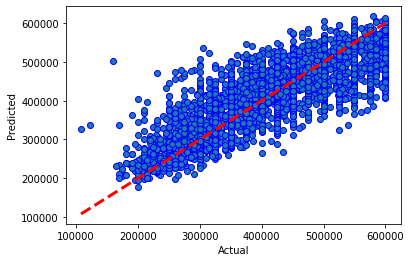

In [40]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [41]:
if not_catboost:
    def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
        graph_model = model
        graph_model.set_params(**graph_params)
        graph_model.fit(X_train, y_train)
        y_pred_graph = model.predict(X_test)

        return model, y_pred_graph


    best_model_count = 10 if not quick_mode else 2
    best_model_count = 3 if not quick_mode else 1
    best_models = {}
    best_model_predictions = {}
    best_model_scores = {}

    showable_increment = total_fits // (4 if not quick_mode else 2)
    for i in range(0, total_fits, showable_increment):
        if debug_mode or True: print(f'{i} ==> {i}')

        if i == 0:
            fitted_graph_model = crossval_runner.best_estimator_
            y_pred_graph = y_pred
        else:
            graph_pipe_params = cv_results_df_sorted['params'][i]
            print(graph_pipe_params)
            # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

            graph_params = {}
            for key, value in graph_pipe_params.items():
                graph_params[key.replace('model__', '')] = value

            fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                            y_train, X_test)

        best_models[i] = fitted_graph_model[-1].get_params()
        best_model_predictions[i] = y_pred_graph
        best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

    if debug_mode or True: print(f'{-1} ==> {-1}')
    graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
    print(graph_pipe_params)
    graph_params = {}
    for key, value in graph_pipe_params.items():
        graph_params[key.replace('model__', '')] = value
    fitted_graph_model, y_pred_graph = custom_model_and_predictions(make_pipeline(), graph_pipe_params, X_train,
                                                                    y_train, X_test)
    best_models[-1] = fitted_graph_model[-1].get_params()
    best_model_predictions[-1] = y_pred_graph
    best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
11 ==> 11
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 50, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.5, 'model__is_unbalance': True, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'goss'}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 425241.939971
22 ==> 22
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 1000, 'model__n_estimators': 132, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.0005, 'model__is_unbalance': False, 'model__colsample_bytree

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


33 ==> 33
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 25, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.005, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'goss'}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 425241.939971
44 ==> 44
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 50, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.005, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, '

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


-1 ==> -1
{'model__verbose': 1, 'model__num_leaves': 20, 'model__num_iterations': 50, 'model__n_estimators': 64, 'model__min_child_samples': 20, 'model__metric': 'auc', 'model__learning_rate': 0.0005, 'model__is_unbalance': False, 'model__colsample_bytree': 0.6, 'model__boosting_type': 'dart'}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 39714, number of used features: 10
[LightGBM] [Info] Start training from score 425241.939971


/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [42]:
cv_results_df_sorted if not_catboost else ''

params2  rank_test_score  \
0      1/20/1000/264/20/auc/0.5/False/0.6/dart                1   
1         1/20/500/64/20/auc/0.5/True/0.6/dart                2   
2        1/20/1000/64/20/auc/0.5/True/0.6/gbdt                3   
3      1/20/1000/132/20/auc/0.5/False/0.6/gbdt                3   
4        1/20/100/264/20/auc/0.5/True/0.6/gbdt                5   
5      1/20/500/264/20/auc/0.05/False/0.6/goss                6   
6       1/20/500/64/20/auc/0.05/False/0.6/goss                6   
7        1/20/50/132/20/auc/0.5/False/0.6/dart                8   
8         1/20/25/264/20/auc/0.5/True/0.6/dart                9   
9         1/20/25/64/20/auc/0.5/False/0.6/dart                9   
10       1/20/50/264/20/auc/0.5/False/0.6/goss               11   
11         1/20/50/64/20/auc/0.5/True/0.6/goss               11   
12      1/20/100/264/20/auc/0.05/True/0.6/goss               13   
13      1/20/500/264/20/auc/0.05/True/0.6/dart               14   
14   1/20/1000/132/20/auc/0.005/False/0.6/goss               15   
15    1/20/1000/64/20/auc/0.005/False/0.6/gbdt               16   
16   1/20/1000/132/20/auc/0.005/False/0.6/gbdt               16   
17     1/20/500/64/20/auc/0.005/False/0.6/goss               18   
18       1/20/25/264/20/auc/0.05/True/0.6/gbdt               19   
19       1/20/25/64/20/auc/0.05/False/0.6/dart               20   
20      1/20/25/264/20/auc/0.05/False/0.6/dart               20   
21       1/20/50/264/20/auc/0.05/True/0.6/dart               22   
22  1/20/1000/132/20/auc/0.0005/False/0.6/gbdt               23   
23  1/20/1000/264/20/auc/0.0005/False/0.6/goss               23   
24   1/20/1000/132/20/auc/0.0005/True/0.6/goss               23   
25   1/20/1000/264/20/auc/0.0005/True/0.6/goss               23   
26    1/20/1000/64/20/auc/0.0005/True/0.6/gbdt               23   
27     1/20/100/132/20/auc/0.005/True/0.6/goss               28   
28   1/20/500/264/20/auc/0.0005/False/0.6/goss               29   
29       1/20/50/64/20/auc/0.005/True/0.6/gbdt               30   
30      1/20/50/64/20/auc/0.005/False/0.6/gbdt               30   
31      1/20/50/132/20/auc/0.005/True/0.6/gbdt               30   
32     1/20/50/132/20/auc/0.005/False/0.6/gbdt               30   
33      1/20/25/64/20/auc/0.005/False/0.6/goss               34   
34     1/20/25/132/20/auc/0.005/False/0.6/goss               34   
35      1/20/25/132/20/auc/0.005/True/0.6/goss               34   
36       1/20/25/64/20/auc/0.005/True/0.6/goss               34   
37     1/20/50/264/20/auc/0.0005/True/0.6/gbdt               38   
38      1/20/50/64/20/auc/0.0005/True/0.6/gbdt               38   
39     1/20/50/64/20/auc/0.0005/False/0.6/gbdt               38   
40    1/20/25/132/20/auc/0.0005/False/0.6/goss               41   
41     1/20/25/64/20/auc/0.0005/False/0.6/dart               42   
42     1/20/25/132/20/auc/0.0005/True/0.6/dart               42   
43     1/20/50/264/20/auc/0.005/False/0.6/dart               44   
44      1/20/50/64/20/auc/0.005/False/0.6/dart               44   
45      1/20/50/132/20/auc/0.005/True/0.6/dart               44   
46     1/20/50/64/20/auc/0.0005/False/0.6/dart               47   

    mean_test_score  mean_fit_time  mean_score_time  \
0          0.694935      15.043873         0.517302   
1          0.688621       5.272155         0.185249   
2          0.674614       1.166172         0.385707   
3          0.674614       1.196901         0.391283   
4          0.664856       0.171882         0.030933   
5          0.663701       1.005136         0.216208   
6          0.663701       1.112875         0.215141   
7          0.638278       0.172500         0.023323   
8          0.634438       0.080586         0.011330   
9          0.634438       0.084543         0.013510   
10         0.629019       0.150964         0.026348   
11         0.629019       0.134426         0.022924   
12         0.616928       0.265187         0.047085   
13         0.616626       8.054902         0.199895 

In [43]:
cv_results_df_sorted['params']  if not_catboost and debug_mode else ''

''

In [44]:
cv_results_df_sorted['params'][0] if not_catboost else ''

{'model__verbose': 1,
 'model__num_leaves': 20,
 'model__num_iterations': 1000,
 'model__n_estimators': 264,
 'model__min_child_samples': 20,
 'model__metric': 'auc',
 'model__learning_rate': 0.5,
 'model__is_unbalance': False,
 'model__colsample_bytree': 0.6,
 'model__boosting_type': 'dart'}

In [45]:
best_models if not_catboost else ''

{0: {'boosting_type': 'dart',
  'class_weight': None,
  'colsample_bytree': 0.6,
  'importance_type': 'split',
  'learning_rate': 0.5,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 264,
  'n_jobs': -1,
  'num_leaves': 20,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0,
  'verbose': 1,
  'num_iterations': 1000,
  'metric': 'auc',
  'is_unbalance': False},
 11: {'boosting_type': 'goss',
  'class_weight': None,
  'colsample_bytree': 0.6,
  'importance_type': 'split',
  'learning_rate': 0.5,
  'max_depth': -1,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 64,
  'n_jobs': -1,
  'num_leaves': 20,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bi

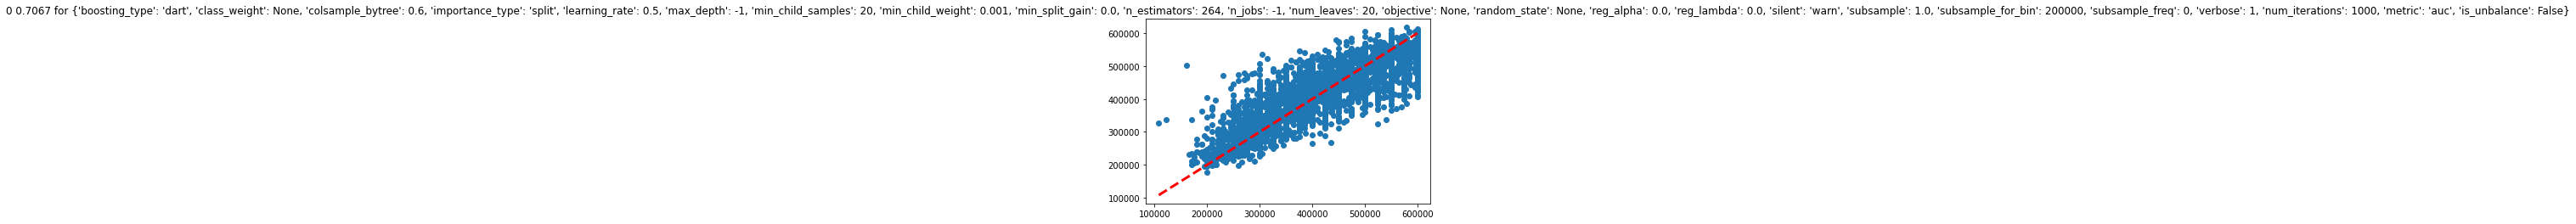

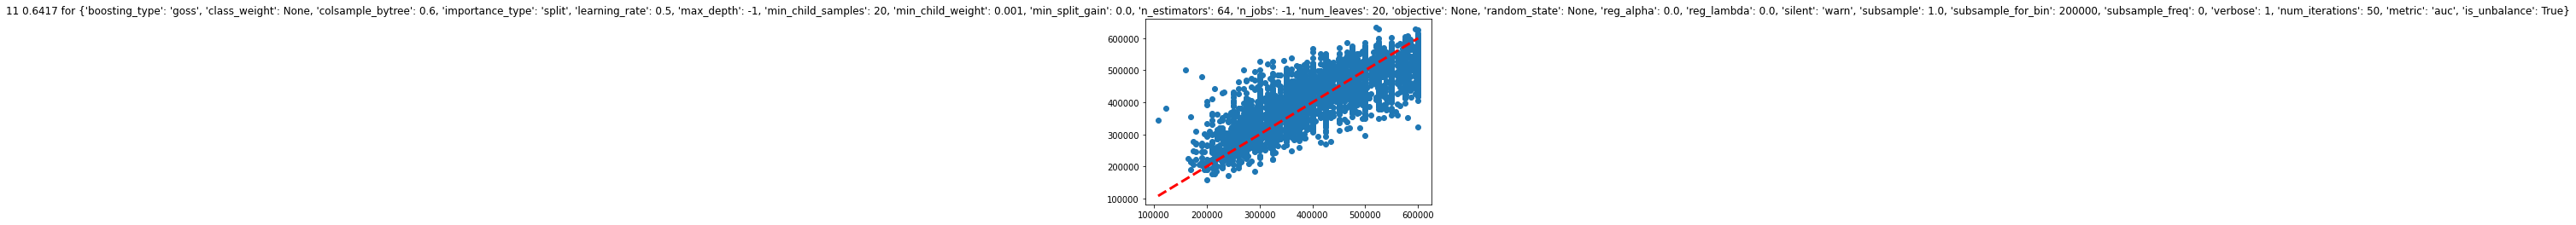

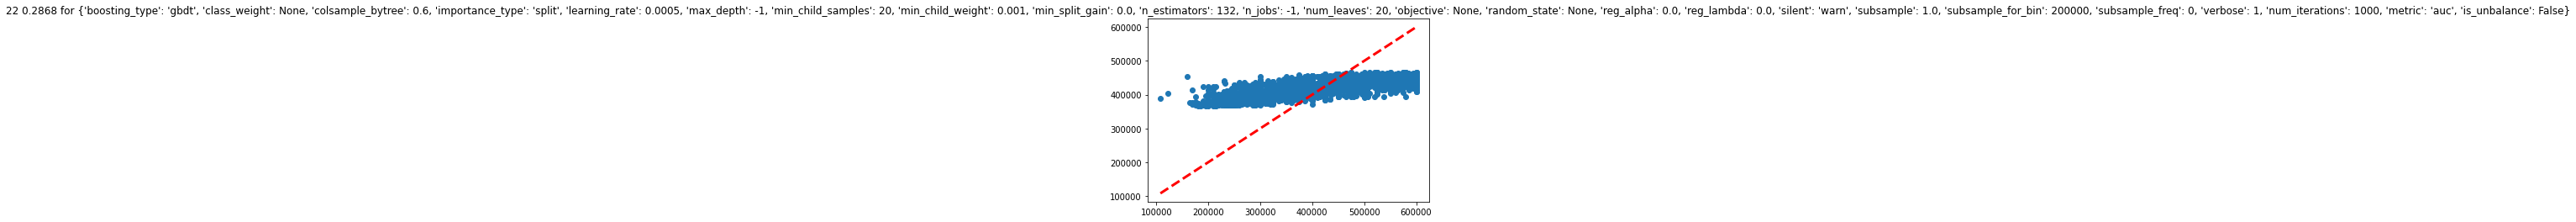

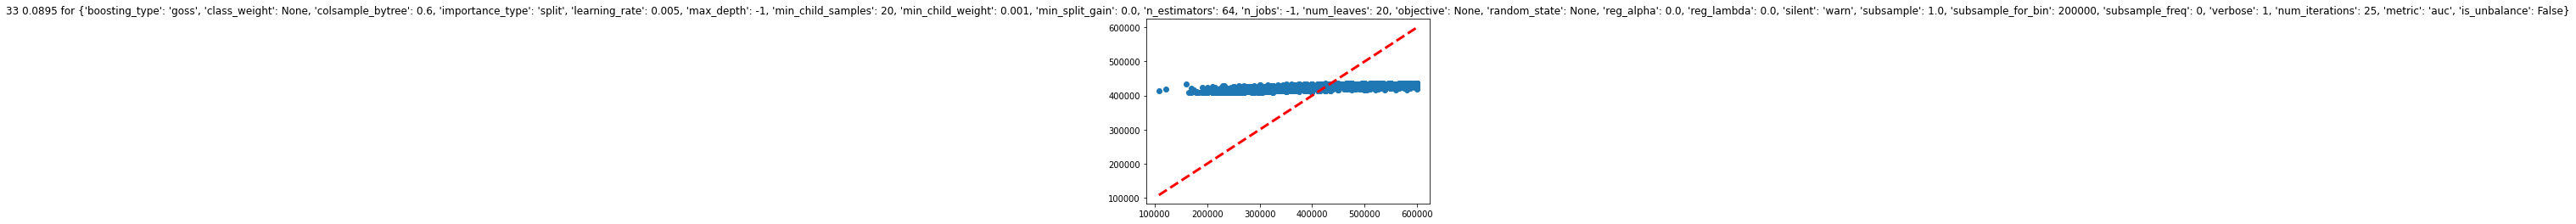

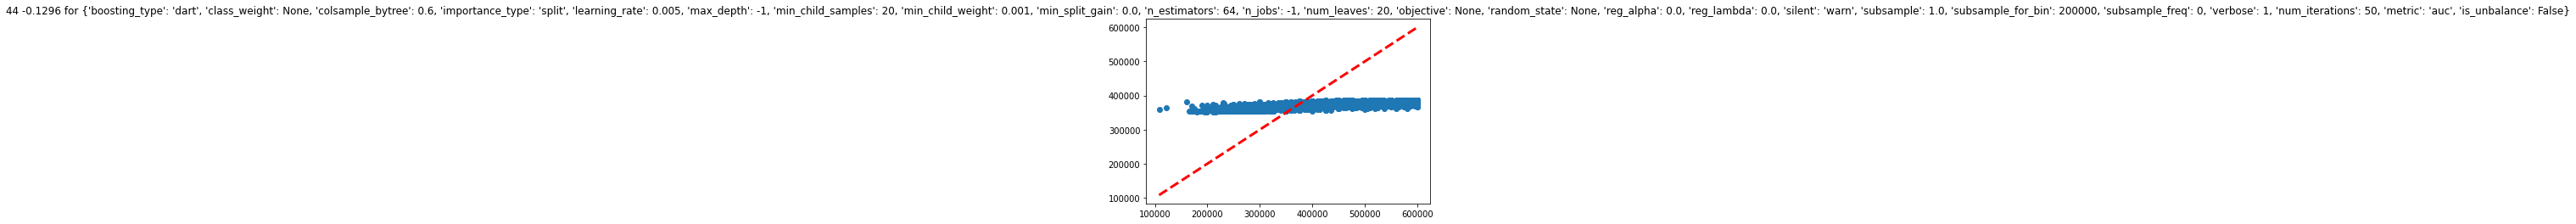

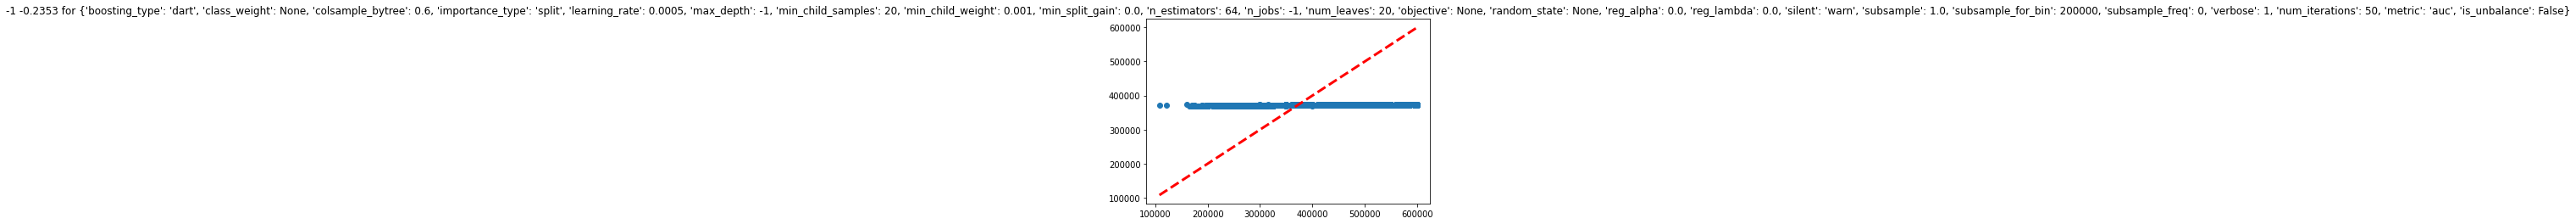

In [46]:
if not_catboost:
    for i in best_model_scores.keys():
        if i >= 0:
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
            plt.scatter(y_test, best_model_predictions[i])
            # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            if len(best_models[i].keys()) < 30:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
            else:
                plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
            plt.show()

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
    plt.scatter(y_test, best_model_predictions[-1])
    # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
    if len(best_models[i].keys()) < 30:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
    else:
        plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

    plt.show()

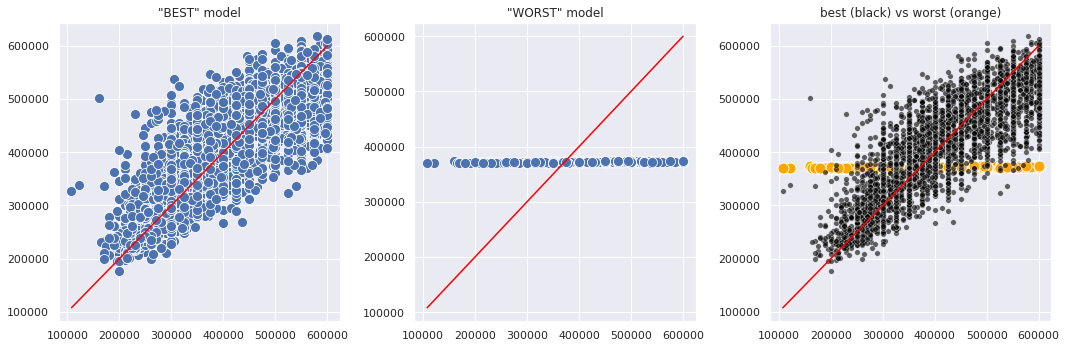

In [47]:
if not_catboost:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [48]:
if not_catboost:
    cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time if not_catboost else ''

15.043873071670532

In [49]:
# <catboost.core.CatBoostRegressor object at 0x7fb167387490>
# {'depth': 6}
# defaultdict(<class 'list'>, {'iterations': [0, 1, 2],
# 'test-RMSE-mean': [396884.9605444017, 359548.6632536235, 326027.84885587444],
# 'test-RMSE-std': [308.9495320039113, 260.0967808594464, 219.65856329246023],
# 'train-RMSE-mean': [396884.77936957515, 359542.3612912551, 326018.9404460669],
# 'train-RMSE-std': [91.44140078375503, 86.77961380623475, 69.4038638987425]})

cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

light gradient boosting (v06)


In [50]:
crossval_runner.best_estimator_  if not_catboost else ''

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(boosting_type='dart', colsample_bytree=0.6,
                               is_unbalance=False, learning_rate=0.5,
                               metric='auc', n_estimators=264,
                               num_iterations=1000, num_leaves=20,
                               verbose=1))])

In [51]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        if not_catboost:
            pickle.dump(crossval_runner.best_estimator_, f)
        else:
            pickle.dump(starter_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)

# 0.45687994672121157 jh

pickled new version of model
0.7067350389592597 is new best score (it's better than 0.5782182084315399)


In [52]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_ if not_catboost else starter_model.get_feature_importance()
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Feature Ranking:
1. features 4 (3481.000000) location.longitude
2. features 6 (3387.000000) longitude_deviation
3. features 5 (3289.000000) latitude_deviation
4. features 3 (3233.000000) location.latitude
5. features 2 (2795.000000) nearestStation
6. features 0 (1151.000000) bedrooms
7. features 1 (549.000000) bathrooms
8. features 9 (478.000000) tenure.tenureType_LEASEHOLD
9. features 8 (461.000000) tenure.tenureType_FREEHOLD
10. features 10 (176.000000) tenure.tenureType_SHARE_OF_FREEHOLD
11. features 7 (0.000000) tenure.tenureType_COMMONHOLD


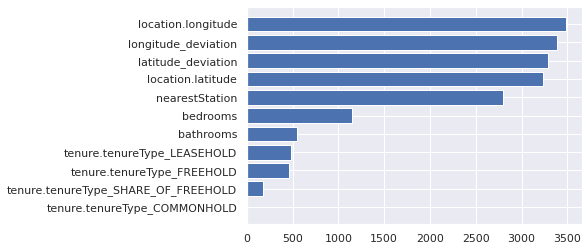

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

In [53]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or 'boost' in ALGORITHM.lower():
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')